In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

In [3]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '1' #use GPU with ID=1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [4]:
from preprocess import divide_to_train_and_test, one_hot
8

In [5]:
def load_from_directory(texts_directory, images_directory, target_names, max_files_in_one_category=30000):
    file_texts = []
    targets = []
    
    for root, dirs, files in os.walk(images_directory):
        number_used_files = 0
        for name in files:
            if number_used_files < max_files_in_one_category:
            
                name_without_extenstion, _ = os.path.splitext(name)
                
                _, cur_target = os.path.split(root)
                cur_target = target_names.index(cur_target)
            
                text_name = name_without_extenstion + ".txt"
                cur_text_path =  os.path.join(texts_directory, text_name)
                
                try:
                    with open(cur_text_path, encoding="utf-16") as file:
                
                        # считываем файл построчно
                        file_text = ""
                        for line in file.readlines():
                            file_text += (line)
                        if file_text != "" and file_text != " ":
                            file_texts.append(file_text[2:])
                            targets.append(cur_target)
                
                            number_used_files += 1            
                except:
                    print("PROBLEM WITH FILE", cur_text_path)
                
    return file_texts, targets


In [6]:
CATEGORIES_COUNT = 7

In [7]:
%%time
file_texts, targets = load_from_directory(texts_directory="D:/svruchtel/DATA/France_New/Texts",
                                         images_directory="D:/svruchtel/DATA/France_New_ByMeaning", 
                                         target_names = ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                                        "Taxi", "TollRoad", "Transport"])

Wall time: 828 ms


In [8]:
text_1 = file_texts[0]
print(text_1)

TAL
RELAIS TOTAL ACCESS EOUGIVAL
TOTAL MARKETING FRANCE
SAS au capital de 39C 553 339 Euro
562 avenue du parc de l'11e
92000 Nanterre - Frarce
37,76 litre pompe 03
GO f E JR 50 00 M
1,324 EUR /litre
Total EJR 50,00
CB EJR 50,00
20,00 % TVA M EJR 8,33
Date Heure Num POS CN° Quart
09/03/17 08:15 59111 11 00J6 051
Vente de carburant faite en mandat
d’ordre et pour le compte Je :
TOTAL MARKETING FRANCE
SAS au capital de 39C 553 339 Euro
562 avenue du parc de T ils
92000 Nanterre - Frarce
531 680 445 RCS Nanterre
No TVA INTRACOM : FR 22 531 680 44�
TOTAL vous remercie ce votre visite
Bonde route et à bientôt



In [9]:
#print(list(text_1))

text_new = [char for char in list(text_1) if (char != ' ' and char != '\n')]
print(text_new)


['T', 'A', 'L', 'R', 'E', 'L', 'A', 'I', 'S', 'T', 'O', 'T', 'A', 'L', 'A', 'C', 'C', 'E', 'S', 'S', 'E', 'O', 'U', 'G', 'I', 'V', 'A', 'L', 'T', 'O', 'T', 'A', 'L', 'M', 'A', 'R', 'K', 'E', 'T', 'I', 'N', 'G', 'F', 'R', 'A', 'N', 'C', 'E', 'S', 'A', 'S', 'a', 'u', 'c', 'a', 'p', 'i', 't', 'a', 'l', 'd', 'e', '3', '9', 'C', '5', '5', '3', '3', '3', '9', 'E', 'u', 'r', 'o', '5', '6', '2', 'a', 'v', 'e', 'n', 'u', 'e', 'd', 'u', 'p', 'a', 'r', 'c', 'd', 'e', 'l', "'", '1', '1', 'e', '9', '2', '0', '0', '0', 'N', 'a', 'n', 't', 'e', 'r', 'r', 'e', '-', 'F', 'r', 'a', 'r', 'c', 'e', '3', '7', ',', '7', '6', 'l', 'i', 't', 'r', 'e', 'p', 'o', 'm', 'p', 'e', '0', '3', 'G', 'O', 'f', 'E', 'J', 'R', '5', '0', '0', '0', 'M', '1', ',', '3', '2', '4', 'E', 'U', 'R', '/', 'l', 'i', 't', 'r', 'e', 'T', 'o', 't', 'a', 'l', 'E', 'J', 'R', '5', '0', ',', '0', '0', 'C', 'B', 'E', 'J', 'R', '5', '0', ',', '0', '0', '2', '0', ',', '0', '0', '%', 'T', 'V', 'A', 'M', 'E', 'J', 'R', '8', ',', '3', '3', 'D',

In [10]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [11]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/wiki.fr.-char.vec", 
                                    max_embeddings_count=300000)

ERROR! Shape is (299,) -0.198018
Wall time: 69.2 ms


In [12]:
print(emb_char_id_to_vector[0][:7])
print(emb_char_id_to_vector[1][:7])
print(emb_char_id_to_vector[112][:7])

[-0.202463  0.223899 -0.013024 -0.219243 -0.012547 -0.257219 -0.151998]
[ 0.666964 -0.067754  0.120445  0.221662 -0.153621  0.096748 -0.396912]
[-0.155307 -0.031068 -0.355434 -0.235345 -0.197813 -0.102845  0.068086]


In [13]:
char_to_id['-']

54

In [14]:
def change_texts_to_lists_of_character_embeddings(X, emb_char_id_to_vector, char_to_id, characters_count=3000):
    """
    X - list of strings (original texts)
    """
    
    X_emb = []
    for text in X:
        text_chars = [char for char in list(text) if (char != ' ' and char != '\n')]
        
        embedded_text = []
        current_chars_count = 0
        
        for char in text_chars:
            if current_chars_count < characters_count:
                if char in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char]])
                    current_chars_count += 1
                elif char.lower() in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char.lower()]])
                    current_chars_count += 1
                #else:
                    #print("There is no embedding to char:", char)
        
        # if text is less long than need to be
        while current_chars_count < characters_count:
            embedded_text.append(emb_char_id_to_vector[char_to_id['-']])
            current_chars_count += 1    
        
        X_emb.append(np.array(embedded_text))
        
    return np.array(X_emb)

In [15]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=100)

Wall time: 3.7 s


In [16]:
char_to_id['f']

25

In [17]:
X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)

y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [18]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(3123, 100, 300)
(352, 100, 300)
(3123, 7)
(352, 7)


### 1

In [19]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape))
model.add(Dense(CATEGORIES_COUNT, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Val accuracy: %.4f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 20s 6ms/step - loss: 1.6219 - acc: 0.4252 - val_loss: 1.4126 - val_acc: 0.5483
Epoch 2/200
3123/3123 [==============================] - 12s 4ms/step - loss: 1.4931 - acc: 0.4947 - val_loss: 1.4469 - val_acc: 0.5426
Epoch 3/200
3123/3123 [==============================] - 11s 4ms/step - loss: 1.4793 - acc: 0.4979 - val_loss: 1.3890 - val_acc: 0.5597
Epoch 4/200
3123/3123 [==============================] - 15s 5ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 160   21    4   85    4   32    3]
 [   6   59   12   46    9   17    4]
 [  12   10  136   31    9   15   23]
 [  20   23   20 1039   10  123   13]
 [   2   14   13   28  169   10    9]
 [   0    2    3   20    7  697    3]
 [   0    8   28   58   16   23   67]]
Normalized confusion matrix
[[0.51779935 0.06796117 0.01294498 0.27508091 0.01294498 0.10355987
  0.00970874]
 [0.03921569 0.38562092 0.07843137 0.30065359 0.05882353 0.11111111
  0.02614379]
 [0.05084746 0.04237288 0.57627119 0.13135593 0.03813559 0.06355932
  0.09745763]
 [0.01602564 0.01842949 0.01602564 0.83253205 0.00801282 0.09855769
  0.01041667]
 [0.00816327 0.05714286 0.05306122 0.11428571 0.68979592 0.04081633
  0.03673469]
 [0.         0.00273224 0.00409836 0.0273224  0.00956284 0.95218579
  0.00409836]
 [0.         0.04       0.14       0.29       0.08       0.115
  0.335     ]]


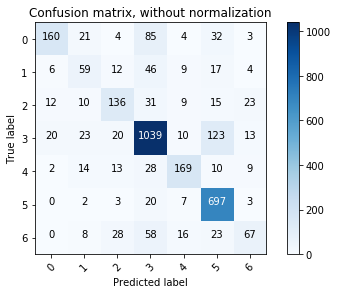

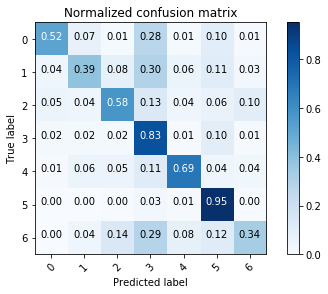

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 16   1   0  10   3   4   1]
 [  1   5   1   3   2   4   2]
 [  0   0  15   5   2   1   4]
 [  8   4   3 101   6  14   3]
 [  0   2   0  13   8   5   0]
 [  0   0   3   4   1  73   1]
 [  1   0   8   5   2   1   6]]
Normalized confusion matrix
[[0.45714286 0.02857143 0.         0.28571429 0.08571429 0.11428571
  0.02857143]
 [0.05555556 0.27777778 0.05555556 0.16666667 0.11111111 0.22222222
  0.11111111]
 [0.         0.         0.55555556 0.18518519 0.07407407 0.03703704
  0.14814815]
 [0.05755396 0.02877698 0.02158273 0.72661871 0.04316547 0.10071942
  0.02158273]
 [0.         0.07142857 0.         0.46428571 0.28571429 0.17857143
  0.        ]
 [0.         0.         0.03658537 0.04878049 0.01219512 0.8902439
  0.01219512]
 [0.04347826 0.         0.34782609 0.2173913  0.08695652 0.04347826
  0.26086957]]


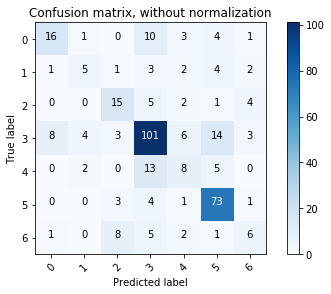

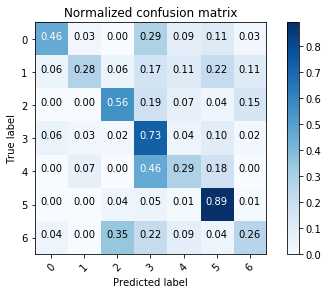

In [20]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [22]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6364


In [23]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_1st_net_train_X_100_chars.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_1st_net_test_X_100_chars.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 14 s


### 2

In [26]:
%%time
# Lets try one another architecture

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 94s 30ms/step - loss: 1.5722 - acc: 0.4633 - val_loss: 1.4333 - val_acc: 0.5426
Epoch 2/200
3123/3123 [==============================] - 90s 29ms/step - loss: 1.5000 - acc: 0.4934 - val_loss: 1.3648 - val_acc: 0.5568
Epoch 3/200
3123/3123 [==============================] - 86s 28ms/step - l

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 212    0    6   77    7    3    4]
 [   2   69    5   46   17    9    5]
 [  19    1  122   42   40    4    8]
 [  47    4    7 1115   18   51    6]
 [   2    4    8   24  198    5    4]
 [   3    0    0   31    9  686    3]
 [  13    5   27   55   30    2   68]]
Normalized confusion matrix
[[0.68608414 0.         0.01941748 0.24919094 0.02265372 0.00970874
  0.01294498]
 [0.0130719  0.45098039 0.03267974 0.30065359 0.11111111 0.05882353
  0.03267974]
 [0.08050847 0.00423729 0.51694915 0.1779661  0.16949153 0.01694915
  0.03389831]
 [0.03766026 0.00320513 0.00560897 0.89342949 0.01442308 0.04086538
  0.00480769]
 [0.00816327 0.01632653 0.03265306 0.09795918 0.80816327 0.02040816
  0.01632653]
 [0.00409836 0.         0.         0.04234973 0.01229508 0.93715847
  0.00409836]
 [0.065      0.025      0.135      0.275      0.15       0.01
  0.34      ]]


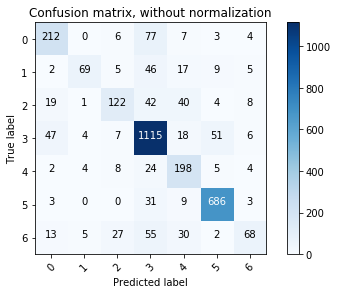

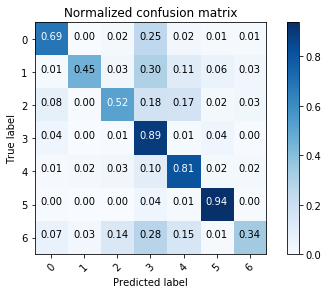

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 22   0   1   9   2   1   0]
 [  1   1   0   8   6   2   0]
 [  2   0  18   2   4   1   0]
 [  5   0   1 113  10   8   2]
 [  0   0   0  19   9   0   0]
 [  1   0   0   7   3  71   0]
 [  1   1   9   6   4   0   2]]
Normalized confusion matrix
[[0.62857143 0.         0.02857143 0.25714286 0.05714286 0.02857143
  0.        ]
 [0.05555556 0.05555556 0.         0.44444444 0.33333333 0.11111111
  0.        ]
 [0.07407407 0.         0.66666667 0.07407407 0.14814815 0.03703704
  0.        ]
 [0.03597122 0.         0.00719424 0.81294964 0.07194245 0.05755396
  0.01438849]
 [0.         0.         0.         0.67857143 0.32142857 0.
  0.        ]
 [0.01219512 0.         0.         0.08536585 0.03658537 0.86585366
  0.        ]
 [0.04347826 0.04347826 0.39130435 0.26086957 0.17391304 0.
  0.08695652]]


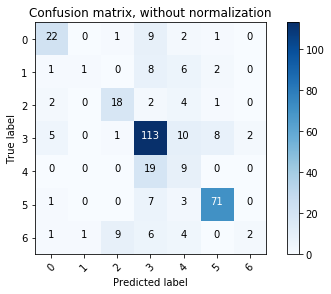

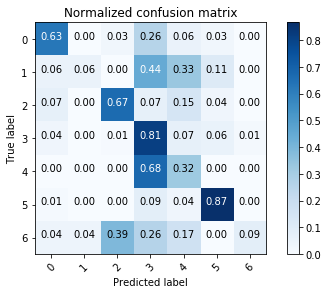

In [27]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [28]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6705


In [29]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_2nd_net_train_X_100_chars.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_2nd_net_test_X_100_chars.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 19.8 s


### 3

In [30]:
%%time
# and another

# with recurrent droupout
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 27s 9ms/step - loss: 1.6388 - acc: 0.4156 - val_loss: 1.4679 - val_acc: 0.5170
Epoch 2/200
3123/3123 [==============================] - 27s 9ms/step - loss: 1.5184 - acc: 0.4829 - val_loss: 1.3975 - val_acc: 0.5511
Epoch 3/200
3123/3123 [==============================] - 26s 8ms/step - loss: 1.4847 - acc: 0.4966 - val_loss: 1.3836 - val_acc: 0.5540
Epoch 4/200
3123/3123 [==============================] - 28s 9ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 170    0    8  113    6    9    3]
 [   0   53    8   73   10    4    5]
 [  12    2  150   58    5    3    6]
 [  24    6   11 1151   11   35   10]
 [   2    2   17   54  159    4    7]
 [   1    2    2   70    5  651    1]
 [   0    2   29   73   14   12   70]]
Normalized confusion matrix
[[0.55016181 0.         0.02588997 0.36569579 0.01941748 0.02912621
  0.00970874]
 [0.         0.34640523 0.05228758 0.47712418 0.06535948 0.02614379
  0.03267974]
 [0.05084746 0.00847458 0.63559322 0.24576271 0.02118644 0.01271186
  0.02542373]
 [0.01923077 0.00480769 0.0088141  0.92227564 0.0088141  0.02804487
  0.00801282]
 [0.00816327 0.00816327 0.06938776 0.22040816 0.64897959 0.01632653
  0.02857143]
 [0.00136612 0.00273224 0.00273224 0.09562842 0.0068306  0.88934426
  0.00136612]
 [0.         0.01       0.145      0.365      0.07       0.06
  0.35      ]]


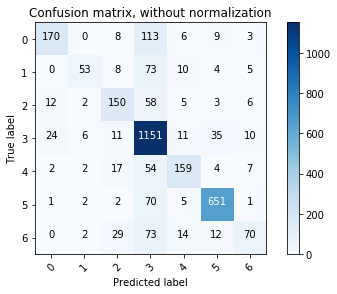

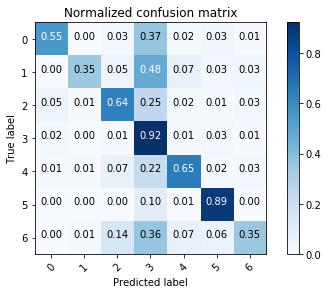

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 17   0   4  11   1   2   0]
 [  1   5   1   6   2   2   1]
 [  1   2  18   4   0   0   2]
 [  4   1   1 122   7   2   2]
 [  0   0   1  18   9   0   0]
 [  0   0   0   9   3  70   0]
 [  2   0   8   5   2   3   3]]
Normalized confusion matrix
[[0.48571429 0.         0.11428571 0.31428571 0.02857143 0.05714286
  0.        ]
 [0.05555556 0.27777778 0.05555556 0.33333333 0.11111111 0.11111111
  0.05555556]
 [0.03703704 0.07407407 0.66666667 0.14814815 0.         0.
  0.07407407]
 [0.02877698 0.00719424 0.00719424 0.87769784 0.05035971 0.01438849
  0.01438849]
 [0.         0.         0.03571429 0.64285714 0.32142857 0.
  0.        ]
 [0.         0.         0.         0.1097561  0.03658537 0.85365854
  0.        ]
 [0.08695652 0.         0.34782609 0.2173913  0.08695652 0.13043478
  0.13043478]]


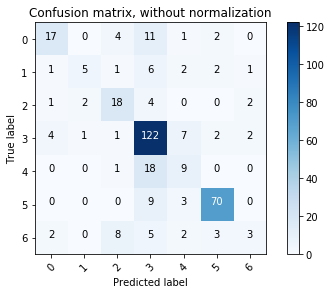

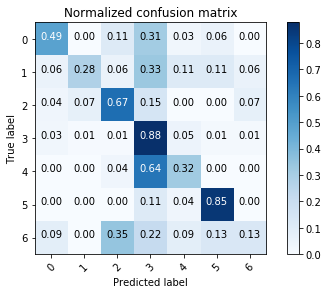

In [31]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [32]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6932


In [33]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_3rd_net_train_X_100_chars.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_3rd_net_test_X_100_chars.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 18.1 s


### 4

In [34]:
%%time
# and two LSTM's

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1407      
Total params: 402,607
Trainable params: 402,607
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 208s 66ms/step - loss: 1.5613 - acc: 0.4595 - val_loss: 1.5376 - val_acc: 0.5398
Epoch 2/200
3123/3123 [==============================] - 182s 58ms/step - loss: 1.4885 - acc: 0.4970 - val_loss: 1.3635 - val_acc: 0.5625
Epoch 3/200
3123/3123 [==============================] - 184s 59ms/step 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 212    3    6   60    3   12   13]
 [   2   85    6   42    5    7    6]
 [   4    3  171   43    7    6    2]
 [  12    8   14 1149   11   45    9]
 [   1    4   19   29  185    1    6]
 [   9    2    0   64    4  644    9]
 [   4    1   25   46    5    7  112]]
Normalized confusion matrix
[[0.68608414 0.00970874 0.01941748 0.19417476 0.00970874 0.03883495
  0.0420712 ]
 [0.0130719  0.55555556 0.03921569 0.2745098  0.03267974 0.04575163
  0.03921569]
 [0.01694915 0.01271186 0.72457627 0.18220339 0.02966102 0.02542373
  0.00847458]
 [0.00961538 0.00641026 0.01121795 0.92067308 0.0088141  0.03605769
  0.00721154]
 [0.00408163 0.01632653 0.07755102 0.11836735 0.75510204 0.00408163
  0.0244898 ]
 [0.01229508 0.00273224 0.         0.08743169 0.00546448 0.87978142
  0.01229508]
 [0.02       0.005      0.125      0.23       0.025      0.035
  0.56      ]]


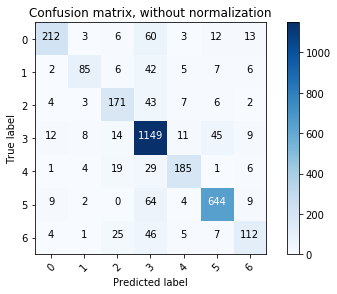

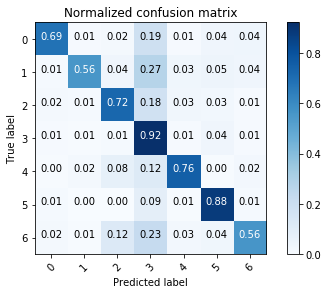

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 19   0   2   8   2   2   2]
 [  0   6   1   7   2   0   2]
 [  0   2  19   4   0   1   1]
 [  5   2   3 118   7   3   1]
 [  3   1   1  11   9   3   0]
 [  0   0   0  10   1  70   1]
 [  0   0   7   9   3   0   4]]
Normalized confusion matrix
[[0.54285714 0.         0.05714286 0.22857143 0.05714286 0.05714286
  0.05714286]
 [0.         0.33333333 0.05555556 0.38888889 0.11111111 0.
  0.11111111]
 [0.         0.07407407 0.7037037  0.14814815 0.         0.03703704
  0.03703704]
 [0.03597122 0.01438849 0.02158273 0.84892086 0.05035971 0.02158273
  0.00719424]
 [0.10714286 0.03571429 0.03571429 0.39285714 0.32142857 0.10714286
  0.        ]
 [0.         0.         0.         0.12195122 0.01219512 0.85365854
  0.01219512]
 [0.         0.         0.30434783 0.39130435 0.13043478 0.
  0.17391304]]


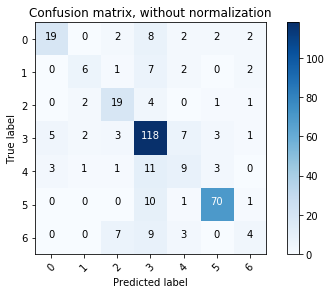

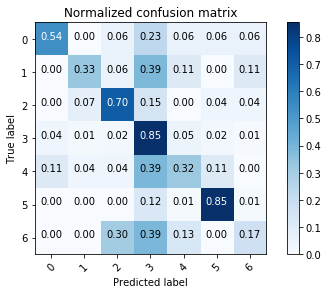

In [35]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [36]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6960


In [37]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_4th_net_train_X_100_chars.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_4th_net_test_X_100_chars.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 32.5 s


### 5

In [20]:
%%time
# and also with 1d-convolutional layer

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 25s 8ms/step - loss: 1.6497 - acc: 0.4102 - val_loss: 1.4693 - val_acc: 0.5398
Epoch 2/200
3123/3123 [==============================] - 15s 5ms/step - loss: 1.49

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 147    2    9  138    4    3    6]
 [   3   52    8   72    6    6    6]
 [  11    6  146   62    7    0    4]
 [  16    7   15 1161    9   28   12]
 [   2    4   16   59  150    5    9]
 [   6    0    3   74    2  641    6]
 [   3    3   31   79    7    9   68]]
Normalized confusion matrix
[[0.47572816 0.00647249 0.02912621 0.44660194 0.01294498 0.00970874
  0.01941748]
 [0.01960784 0.33986928 0.05228758 0.47058824 0.03921569 0.03921569
  0.03921569]
 [0.04661017 0.02542373 0.61864407 0.26271186 0.02966102 0.
  0.01694915]
 [0.01282051 0.00560897 0.01201923 0.93028846 0.00721154 0.0224359
  0.00961538]
 [0.00816327 0.01632653 0.06530612 0.24081633 0.6122449  0.02040816
  0.03673469]
 [0.00819672 0.         0.00409836 0.1010929  0.00273224 0.87568306
  0.00819672]
 [0.015      0.015      0.155      0.395      0.035      0.045
  0.34      ]]


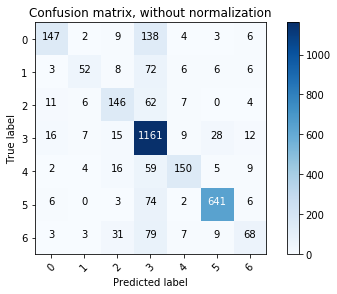

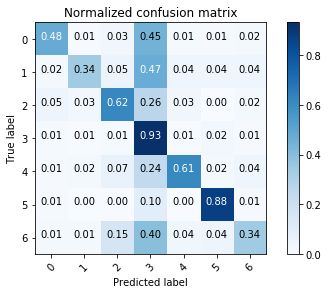

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 14   0   2  15   1   2   1]
 [  0   2   4   9   0   2   1]
 [  0   0  19   6   0   0   2]
 [  5   0   1 124   3   5   1]
 [  0   2   0  14  11   0   1]
 [  0   0   0   9   0  73   0]
 [  2   0   9   6   0   1   5]]
Normalized confusion matrix
[[0.4        0.         0.05714286 0.42857143 0.02857143 0.05714286
  0.02857143]
 [0.         0.11111111 0.22222222 0.5        0.         0.11111111
  0.05555556]
 [0.         0.         0.7037037  0.22222222 0.         0.
  0.07407407]
 [0.03597122 0.         0.00719424 0.89208633 0.02158273 0.03597122
  0.00719424]
 [0.         0.07142857 0.         0.5        0.39285714 0.
  0.03571429]
 [0.         0.         0.         0.1097561  0.         0.8902439
  0.        ]
 [0.08695652 0.         0.39130435 0.26086957 0.         0.04347826
  0.2173913 ]]


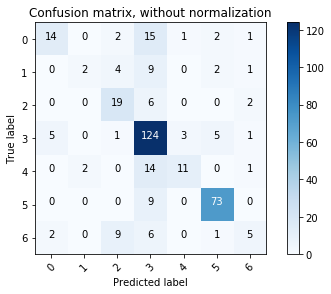

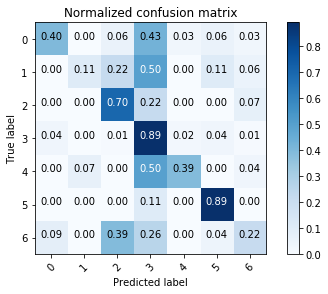

In [21]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [22]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7045


In [23]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_5th_net_train_X_100_chars.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_5th_net_test_X_100_chars.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 12 s


### 6

In [24]:
%%time

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 71s 23ms/step - loss: 1.5380 - acc: 0.4701 - val_loss: 1.3836 - val_acc: 0.5483
Epoch 2/200
3123/3123 [==============================] - 67s 22ms/step - loss: 1.

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 230    1    7   49    3    7   12]
 [   0   92    8   32    2   13    6]
 [   5    4  185   22    4    7    9]
 [  12   14   24 1136    6   45   11]
 [   3    7   19   15  191    5    5]
 [   3    1    3   34    3  679    9]
 [   7    5   22   35    4    9  118]]
Normalized confusion matrix
[[0.74433657 0.00323625 0.02265372 0.15857605 0.00970874 0.02265372
  0.03883495]
 [0.         0.60130719 0.05228758 0.20915033 0.0130719  0.08496732
  0.03921569]
 [0.02118644 0.01694915 0.78389831 0.09322034 0.01694915 0.02966102
  0.03813559]
 [0.00961538 0.01121795 0.01923077 0.91025641 0.00480769 0.03605769
  0.0088141 ]
 [0.0122449  0.02857143 0.07755102 0.06122449 0.77959184 0.02040816
  0.02040816]
 [0.00409836 0.00136612 0.00409836 0.04644809 0.00409836 0.92759563
  0.01229508]
 [0.035      0.025      0.11       0.175      0.02       0.045
  0.59      ]]


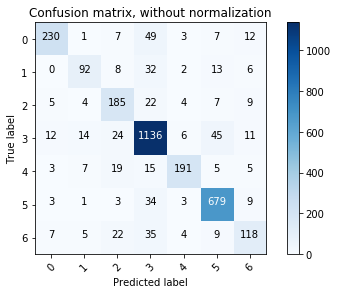

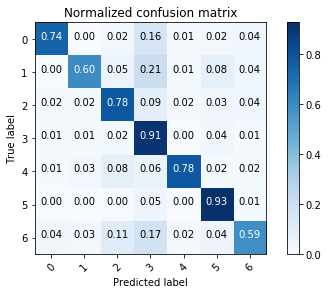

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 22   0   4   8   1   0   0]
 [  1   5   2   7   1   1   1]
 [  0   1  20   3   1   0   2]
 [  6   0   7 118   2   5   1]
 [  0   1   0  14  10   3   0]
 [  1   0   2   7   0  72   0]
 [  1   0  13   2   2   0   5]]
Normalized confusion matrix
[[0.62857143 0.         0.11428571 0.22857143 0.02857143 0.
  0.        ]
 [0.05555556 0.27777778 0.11111111 0.38888889 0.05555556 0.05555556
  0.05555556]
 [0.         0.03703704 0.74074074 0.11111111 0.03703704 0.
  0.07407407]
 [0.04316547 0.         0.05035971 0.84892086 0.01438849 0.03597122
  0.00719424]
 [0.         0.03571429 0.         0.5        0.35714286 0.10714286
  0.        ]
 [0.01219512 0.         0.02439024 0.08536585 0.         0.87804878
  0.        ]
 [0.04347826 0.         0.56521739 0.08695652 0.08695652 0.
  0.2173913 ]]


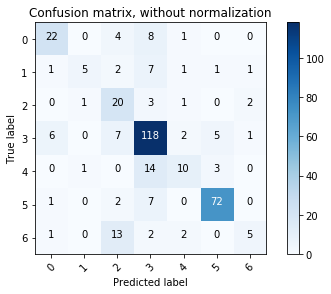

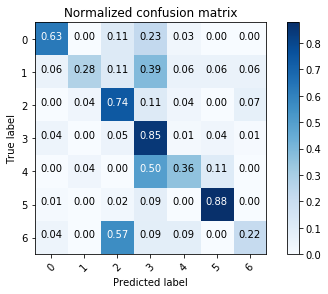

In [25]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [26]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7159


In [27]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaning_6th_net_train_X_100_chars.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaning_6th_net_test_X_100_chars.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 13.3 s
